# Kovarianz

In [1]:
# Definition der benötigten Funktionspakete

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import os

## Wir erstellen ein künstliches (quasi-analoges) Signal

In [2]:
N = 1001 # Länge des Datenvektors
t = np.linspace(0, N-1, N) # Zeitvektor von Punkten mit Abstand 1 in Einheit von Nanosekunden (als konkretes Beispiel)
# t_tot = N ns für unser Beispiel

f_sig = 0.01
Amp1 = 1.2 
Amp3 = 5.2
sig1 = Amp1*np.sin(2*np.pi*f_sig*t)
sig2 = Amp1*np.cos(2*np.pi*f_sig*t)
sig3 = Amp3*np.sin(2*np.pi*f_sig*t)
noise_amp = 0.1
noise1 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
noise2 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
noise3 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
U1 = sig1 + noise1
U2 = sig2 + noise2
U3 = sig3 + noise3

Text(0, 0.5, 'echte Spannung [V]')

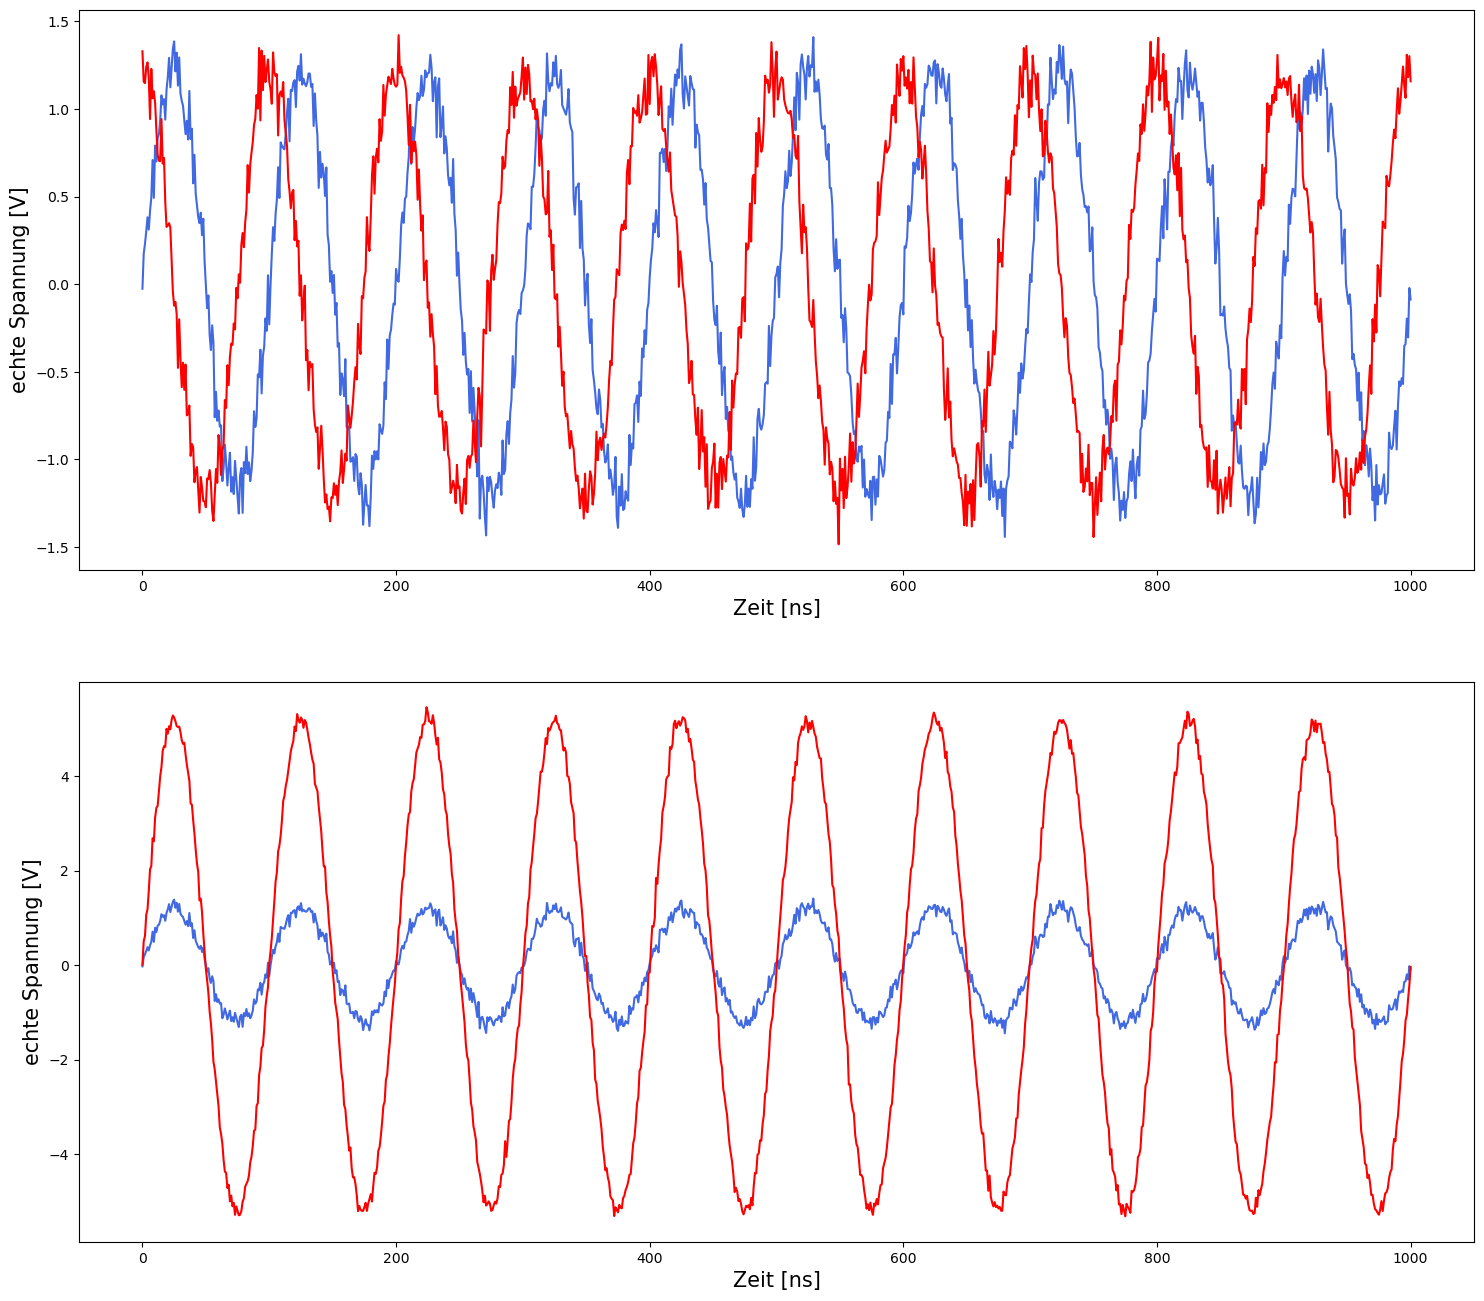

In [16]:
fig, ax = plt.subplots(2, figsize=(18, 16))
ax[0].plot(t, U1, color='royalblue')
ax[0].plot(t, U2, color='red')
ax[0].set_xlabel('Zeit [ns]', fontsize = 15)
ax[0].set_ylabel('echte Spannung [V]', fontsize = 15)
ax[1].plot(t, U1, color='royalblue')
ax[1].plot(t, U3, color='red')
ax[1].set_xlabel('Zeit [ns]', fontsize = 15)
ax[1].set_ylabel('echte Spannung [V]', fontsize = 15)

Text(0, 0.5, 'gemessene Spannung [V]')

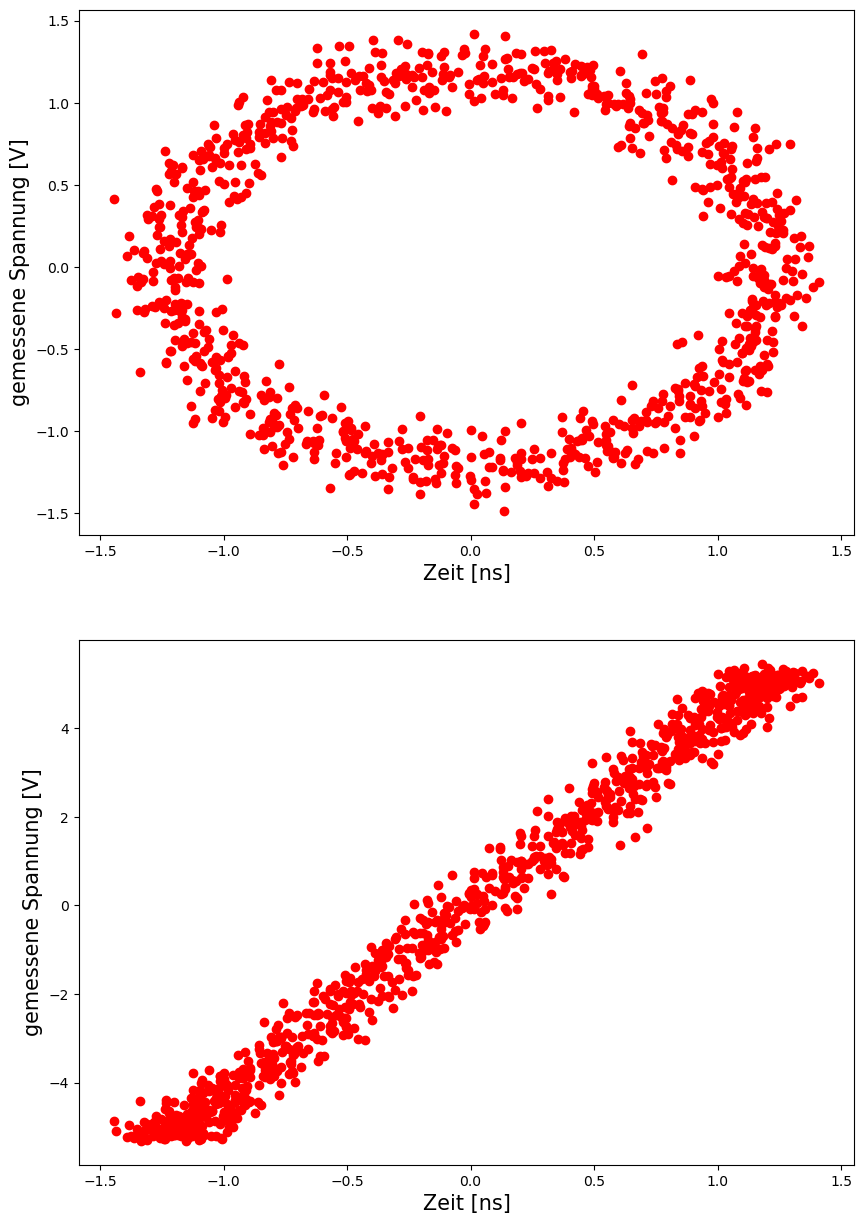

In [15]:
fig, ax = plt.subplots(2, figsize=(10, 15))
ax[0].scatter(U1, U2, color = "red", marker='o')
ax[0].set_xlabel('Zeit [ns]', fontsize = 15)
ax[0].set_ylabel('gemessene Spannung [V]', fontsize = 15)
ax[1].scatter(U1, U3, color = "red", marker='o')
ax[1].set_xlabel('Zeit [ns]', fontsize = 15)
ax[1].set_ylabel('gemessene Spannung [V]', fontsize = 15)

## Bestimmung der Kovarianz

In [20]:
C = np.stack((U1,U2), axis=0)
np.cov(C)
print(np.corrcoef(C))
C = np.stack((U1,U3), axis=0)
np.cov(C)
print(np.corrcoef(C))

[[1.         0.00181581]
 [0.00181581 1.        ]]
[[1.         0.99291556]
 [0.99291556 1.        ]]


## Wir "messen" unser Signal mit einem simulierten Analog-Digital-Konverter (ADC)
### Wir wählen ideale ADC-Parameter, um die "echte" Messung zu sehen, U_mess = U. Den Einfluss nicht-idealer Parameter kann man leicht selber erforschen.

In [21]:
Delta_t = 1 # zeitl. Abstand der Messpunkte in den gewählten Einheiten: für einen Zeitvektor t mit Abständen von je 1 Nanosekunde misst unser ADC einen Datenpunkt alle Delta_t Nanosekunden
U_max = 10 # maximal messbarer Wert: alle grösseren Werte werden als U_max angezeigt ("clipping")
U_min = 0.1 # minimaler messbarer Spannungsunterschied der Signalwerte: Spannungsauflösung des ADC
U_noise = 1.5 # Standardabweichung des Spannungsrauschens, das dem Signal durch den Messprozess hinzigefügt wird

# Initialisierung der Messvektoren
n_mess = math.floor(N/Delta_t)-1 # Anzahl gemesener Punkte. "floor" rundet ab
n = range(n_mess) # wird für for loop benötigt, enthält 0 und n_mess als untere und obere Grenze von n
#print(n_mess)
t_mess = np.zeros(n_mess) # leerer Vektor, um die Zeitwerte zu erfassen
U1_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen
U2_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen
U3_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen

for i in n:
    t_mess[i] = t[(i+1)*Delta_t] # jeder (i+1)*Delta_t-te Punkt wird gemessen
    U1_mess[i] = np.clip(U_min*round((U1[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]
    U2_mess[i] = np.clip(U_min*round((U2[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]
    U3_mess[i] = np.clip(U_min*round((U3[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]

Text(0, 0.5, 'gemessene Spannung [V]')

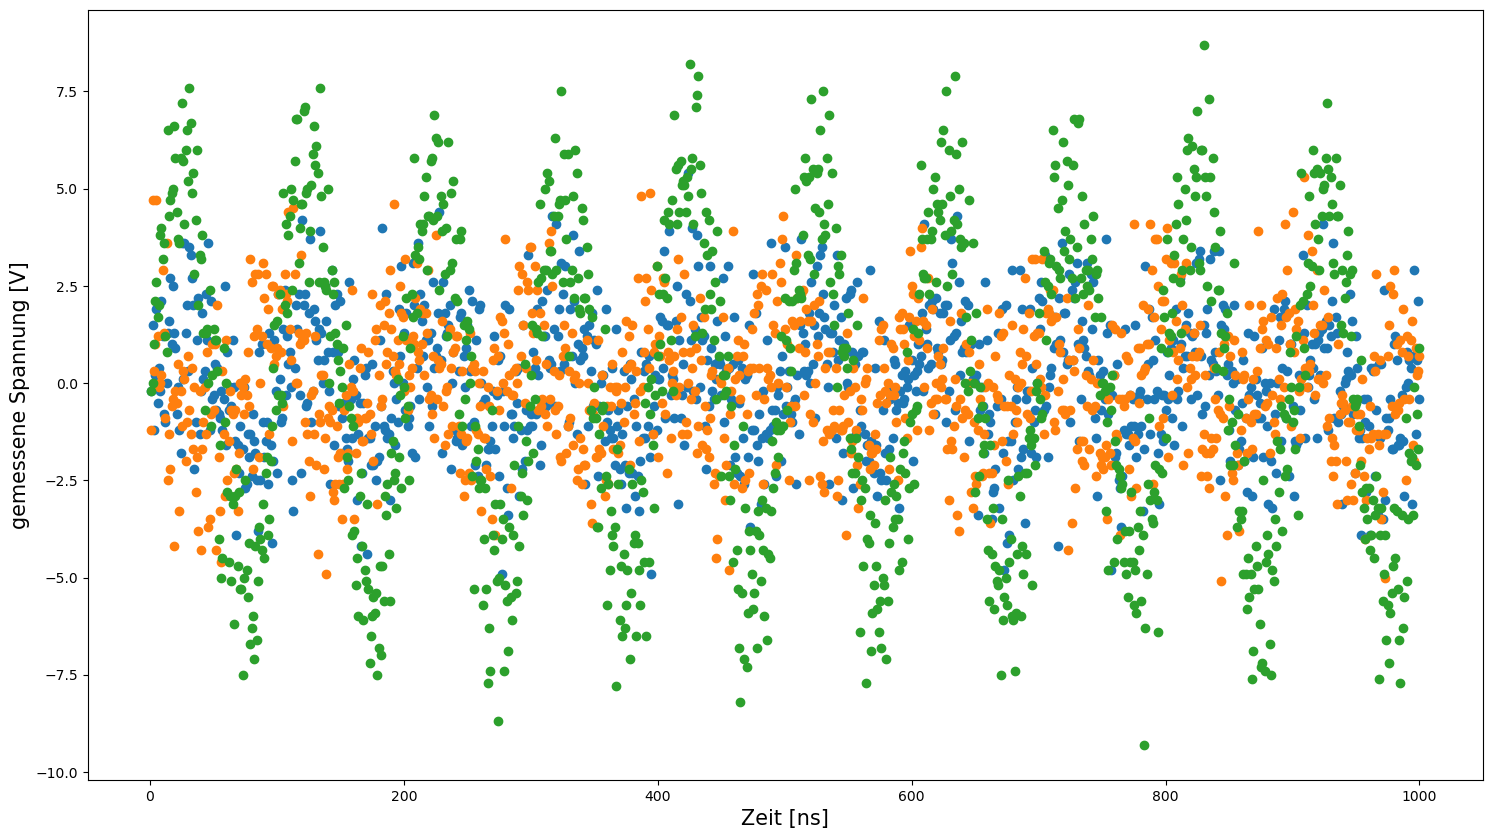

In [38]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(t_mess, U1_mess, marker='o')
ax.scatter(t_mess, U2_mess, marker='o')
ax.scatter(t_mess, U3_mess, marker='o')
ax.set_xlabel('Zeit [ns]', fontsize = 15)
ax.set_ylabel('gemessene Spannung [V]', fontsize = 15)

## Bestimmung der Kovarianz

In [39]:
C = np.stack((U1_mess,U3_mess), axis=0)
np.cov(C)
np.corrcoef(C)

array([[1.        , 0.43329902],
       [0.43329902, 1.        ]])

In [40]:
# vergleiche Varianzen vor und nach ADC
print(np.var(U1))
print(np.var(U1_mess))

0.7465163881632385
2.9688397500000003


## Bestimmung der Auto-Kovarianz

In [41]:
# definiere Auto-Kovarianzfunktion

def Rxx(x, delta):
    xm = np.mean(x)
    dev_sum = 0
    for i in range(len(x) - delta):
        dev_sum += (x[i] - xm) * (x[i + delta] - xm)
    return dev_sum / (len(x) - delta)

Text(0, 0.5, 'Rxx')

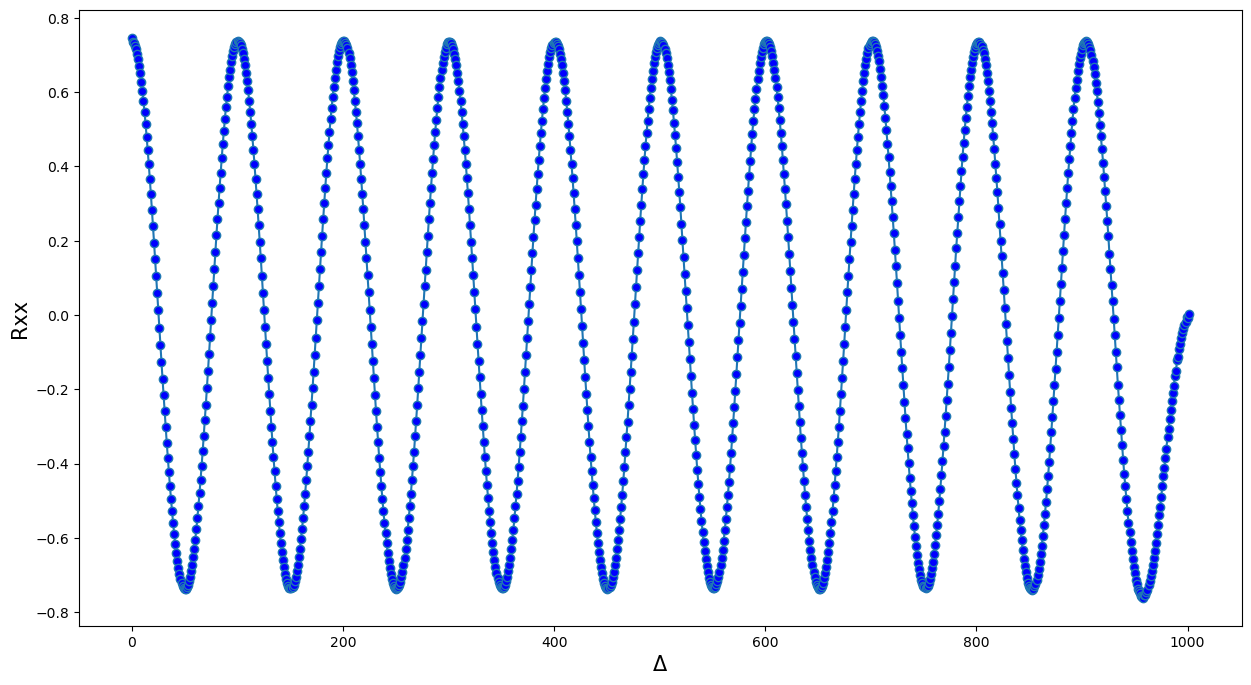

In [42]:
# wende Funktion auf Beispiele an

delta_max = len(U1)

Rxx_vs_delta = [Rxx(U1, i) for i in range(delta_max)]

lags = np.linspace(0, delta_max, num=delta_max)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lags, Rxx_vs_delta, linestyle='-', marker='o', markerfacecolor='blue')
ax.set_xlabel('$\Delta$', fontsize = 15)
ax.set_ylabel('Rxx', fontsize = 15)

## Ultraschneller Laserpuls

Text(0, 0.5, 'echte Spannung [V]')

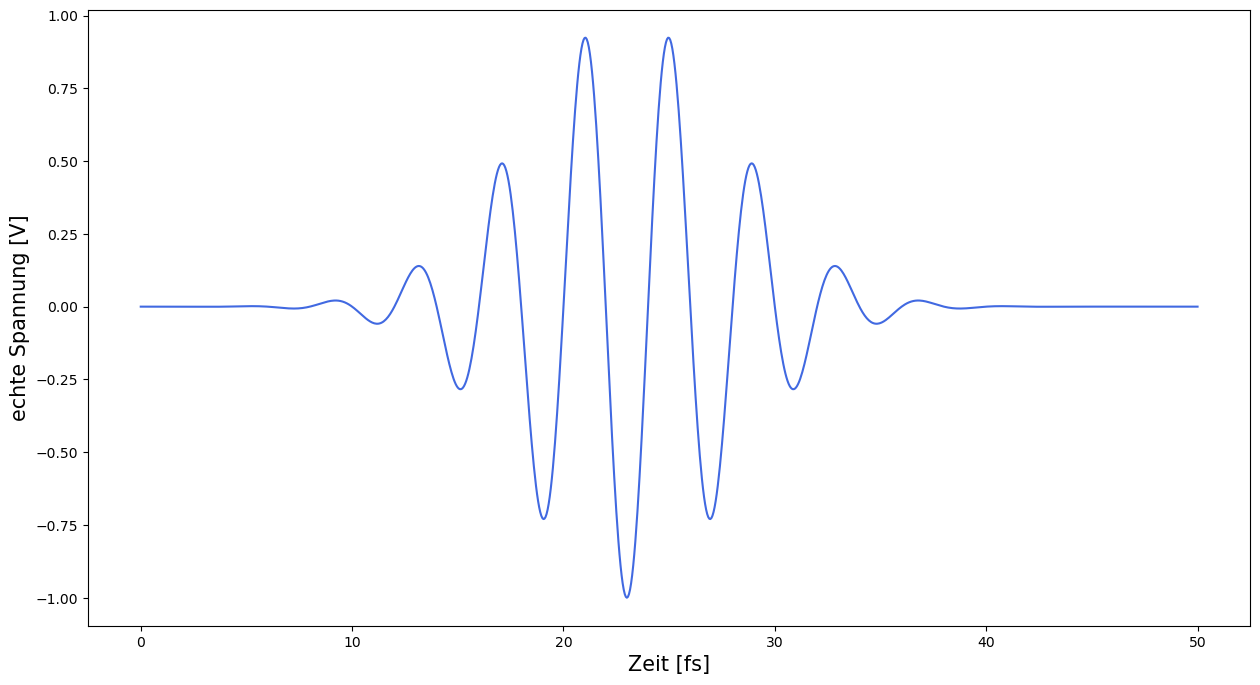

In [43]:
N = 1001 # Länge des Datenvektors
t = np.linspace(0, (N-1)/20, N) # Zeitvektor in Einheit von Femtosekunden (0.000000000000001 s)
# das Verhältnis einer fs zu einer Sekunde entspricht dem Verhältnis einer Sekunde zu 32 Mio Jahren
# t_tot = N fs für unser Beispiel

f_sig = 0.25
Amp = 1
pulse_time = 5
E = Amp*np.sin(2*np.pi*f_sig*t)*np.exp(-0.5*(t-23)**2/pulse_time**2)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(t, E, color='royalblue', label="E-Feld")
ax.set_xlabel('Zeit [fs]', fontsize = 15)
ax.set_ylabel('echte Spannung [V]', fontsize = 15)

Text(0, 0.5, 'Rxx')

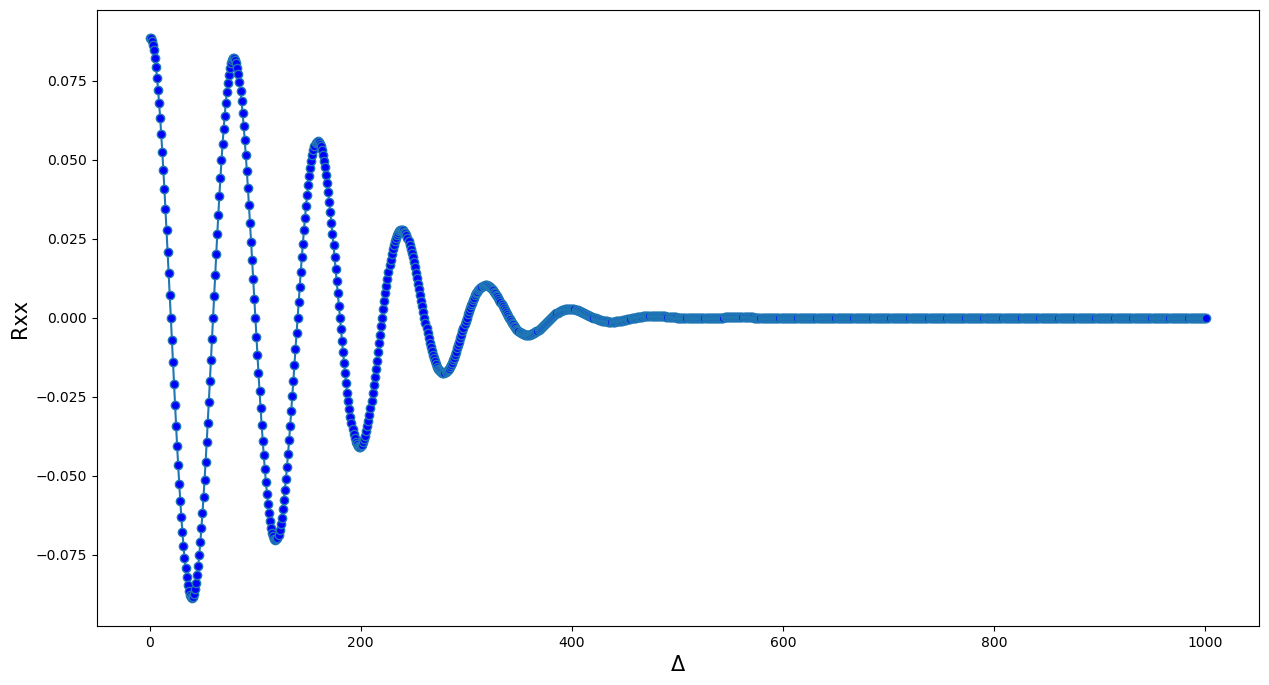

In [44]:
delta_max = len(E)

Rxx_vs_delta = [Rxx(E, i) for i in range(delta_max)]

lags = np.linspace(0, delta_max, num=delta_max)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(lags, Rxx_vs_delta, linestyle='-',marker='o',markerfacecolor='blue')
ax.set_xlabel('$\Delta$', fontsize = 15)
ax.set_ylabel('Rxx', fontsize = 15)